In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

In [2]:
α = 4

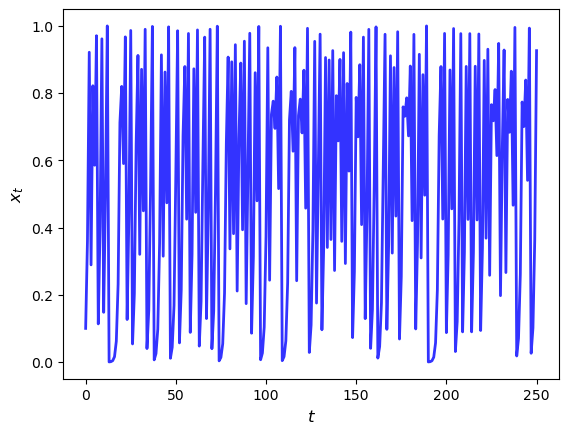

In [ ]:
# native implementation of the difference equation
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
      x[t+1] = α * x[t] * (1 - x[t])
    return x

x = qm(0.1, 250)
fig, ax = plt.subplots()
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$x_{t}$', fontsize = 12)
plt.show()

In [4]:
from numba import jit

# qm_numba is the qm function but already precompiled with jit
qm_numba = jit(qm)

In [9]:
# benchmarking native vs numba to test the difference
n = 100_000_000

qe.tic()
qm(0.1, int(n))
time1 = qe.toc()

qe.tic()
qm_numba(0.1, int(n))
time2 = qe.toc()

speedgain = time1/time2
print(speedgain)

# for n = 100,000,000:
# native: 30.36 sec
# numba: 0.25 sec

TOC: Elapsed: 0:00:30.48
TOC: Elapsed: 0:00:0.27
110.89379479494065


# Ex 17.1: Compute $\pi$ with Monte Carlo
We've previously used Monte Carlo to approximate the value of $\pi$. Now, we'll speed it up using `numba`. Compare the time taken for the old implementation and the `numba` one.

In [ ]:
# ------------------------------------------------ old implementation ------------------------------------------------ #
# create a unit square and inscribe a quadrant in it. the ratio of their areas is pi/4.
# randomly place dots in the square. calculate the ratio of the dots within 1 unit from the origin (in the quadrant)
# and more than 1 unit away (in square, but not in quadrant).
# multiply the ratio by 4 to get pi
# YOU CAN ONLY USE NUMPY
import numpy as np
import time
from numba import njit

start_old = time.time()

n = 10**8  # increase n to increase accuracy of the estimation
h = np.random.rand(n)
k = np.random.rand(n)
points = [(0, 0)] * n  # list of all points

quadrant = 0  # points in the quadrant (d<1)
square = 0  # points in the square and not in the quadrant (d>1)

index = 0
for i, j in zip(h, k):
    points[index] = (i, j)
    index += 1

distance = [None] * n
distance = np.sqrt((h ** 2) + (k ** 2))

for d in distance:
    if d <= 1:
        quadrant += 1
    else:
        square += 1

ratio = quadrant / (quadrant + square)
π = ratio * 4

end_old = time.time()
print(π)

# ------------------------------------------ numba implementation ---------------------------------------- #
@njit
def calc_pi(n):  # n = number of iterations, higher n = more accurate
    p = np.random.rand(n)
    q = np.random.rand(n)
    points = [(0, 0)] * n  # list of all points

    quadrant = 0  # points in the quadrant (d<1)
    square = 0  # points in the square and not in the quadrant (d>1)

    index = 0
    for i, j in zip(p, q):
        points[index] = (i, j)
        index += 1

    distance = np.sqrt((p ** 2) + (q ** 2))

    for d in distance:
        if d <= 1:
            quadrant += 1
        else:
            square += 1

    ratio = quadrant / (quadrant + square)
    π = ratio * 4
    return π

# time the numba implementation
start_numba = time.time()
pi_estimate = calc_pi(n)
end_numba = time.time()
print(pi_estimate)

print("Old implementation:")
print(f"Time taken: {end_old - start_old:.6f} seconds\n")

print("Numba implementation:")
print(f"Time taken: {end_numba - start_numba:.6f} seconds")

# ---------------------------------------------------- RESULTS!!! ---------------------------------------------------- #
# for n = 10**8
# numpy implementation: 51.767249 seconds
# numba implementaiton: 23.842400 seconds

3.14156868
3.14161248
Old implementation:
Time taken: 51.767249 seconds

Numba implementation:
Time taken: 23.842400 seconds


# Ex 17.2
In the Introduction to Quantitative Economics with Python lecture series you can learn all about finite-state Markov chains.

For now, let’s just concentrate on simulating a very simple example of such a chain.

Suppose that the volatility of returns on an asset can be in one of two regimes — high or low.


For example, let the period length be one day, and suppose the current state is high.

We see from the graph that the state tomorrow will be

    high with probability 0.8

    low with probability 0.2

If the current state is low, returns tomorrow will be `low with a probability 0.9 or high with a probability 0.1`.

Your task is to simulate a sequence of daily volatility states according to this rule.

Set the length of the sequence to n = 1_000_000 and start in the high state.

Implement a pure Python version and a Numba version, and compare speeds.

To test your code, evaluate the fraction of time that the chain spends in the low state.

If your code is correct, it should be about 2/3.

In [ ]:
# ---------------------------------------------------- pure python --------------------------------------------------- #
"""Let 0 => low returns and 1 => high returns"""
import time
import random

n = 10**9
chain = [17] * (n)

start_native = time.time()

for i in range(1,n):
    chain[0] = 0 # chain starts at low state, but it doesnt matter for a large n

    randomnum = random.randint(1,10) # using a random number to account for the probability part in a markov chain
    # for low returns
    if chain[i-1] == 0:
        if randomnum == 10:
            chain[i] = 1 # 0.1 probability to shift to the high state
        else:
            chain[i] = 0
    # for high returns
    elif chain[i-1] == 1:
        if randomnum >= 9:
            chain[i] = 0 # 0.2 probability to shift to the low state
        else:
            chain[i] = 1

end_native = time.time()

# used this to verify that 2/3rds of the chain is in the low state
"""lowstate = 0 # to eval the fraction of time the chain is in a low state
for k in chain:
    if k == 0:
        lowstate += 1
print(f"Lowstate = {lowstate}, total = {len(chain)}")
print(f"This chain spends {lowstate/len(chain)*100}% of the time in a low return state")"""

# ------------------------------------------- numba + numpy implementation! ------------------------------------------ #
from numba import njit
import numpy as np

start_numba = time.time()
@njit
def markov_chain(n):
    chain = np.full(n,17)
    chain[1] = 0 # starts in a low state
    for i in range(1,n):
        randomnumber = random.randint(1,10)
        # low returns
        if chain[i-1] == 0:
            if randomnumber == 10:
                chain[i] = 1 # 0.1 probability to go from low to high
            else:
                chain[i] = 0

        # high returns
        if chain[i-1] == 1:
            if randomnumber >= 9:
                chain[i] = 0 # 0.2 probability to go from high to low
            else:
                chain[i] = 1

markov_chain(n)
end_numba = time.time()

print(f"Native implementation: {end_native - start_native:.6f} seconds")
print(f"Numba implementation: {end_numba - start_numba:.6f} seconds")

# ---------------------------------------------------- RESULTS!!! ---------------------------------------------------- #
# for small n, native is usually faster than numba since the numba overhead is greater than any performance gain at that small n

# for n = 10**8,
# Native implementation: 50.175730 seconds
# Numba implementation: 0.765831 seconds
# 65.518 times faster

# for n = 10**9,
# Native implementation: 533.372192 seconds
# Numba implementation: 30.850792 seconds
# 17.289 times faster

Native implementation: 533.372192 seconds
Numba implementation: 30.850792 seconds
